# 蠟燭線回測
### 初始資料拿取

In [3]:
import numpy as np
import pandas as pd
from talib import abstract
from finlab.data import Data

%matplotlib inline

data = Data()

close = data.get_adj('收盤價')
open_ = data.get_adj('開盤價') # 復權之後的價格

# 原本可能是上漲遇到三顆星星後可能會下跌 or 原本是跌後來變漲
signal = data.talib('CDLTRISTAR')

In [4]:
signal.unstack()[signal.unstack() != 0]

      date      
0015  2012-03-12   -100
      2012-05-21    100
      2012-11-01    100
0050  2012-11-19    100
      2015-04-01   -100
0051  2015-04-13    100
0052  2009-02-26   -100
      2009-12-10    100
      2010-04-21    100
      2010-07-30   -100
      2011-01-12    100
      2011-06-28    100
      2012-05-11    100
      2012-10-24   -100
      2013-09-18   -100
      2013-10-28   -100
      2013-12-17    100
      2014-05-12    100
      2014-12-10    100
      2014-12-11   -100
      2014-12-12    100
      2014-12-15   -100
      2016-01-30   -100
      2016-02-01    100
      2016-03-25    100
      2016-09-01   -100
      2016-09-02    100
      2016-10-12   -100
      2016-12-08    100
      2017-01-06   -100
                   ... 
9949  2016-05-18   -100
      2016-11-10    100
      2018-03-05    100
      2018-08-08    100
      2019-01-23    100
9950  2008-09-03    100
      2013-10-28   -100
      2016-05-11   -100
      2016-12-29   -100
      2019-06-06   -100

### 計算買入時間

In [11]:
sids = close.columns[:10]

signal = signal[sids]
close = close[sids]
open_ = open_[sids]

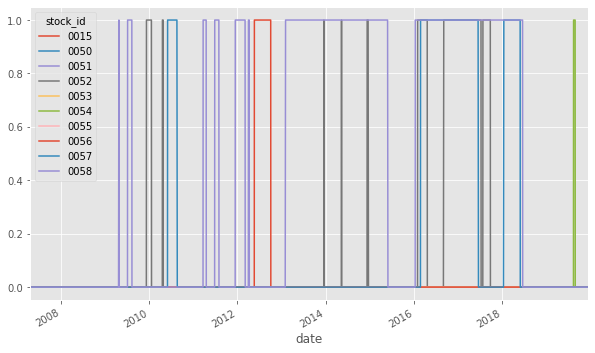

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# 買賣的訊號
buy = (signal > 0)
sell = close < close.rolling(20).mean()
    
# hold = 持有的時間
hold = pd.DataFrame(np.nan, index=close.index, columns=close.columns)
hold[buy] = 1 # buy訊號發生hold變成1
hold[sell] = 0 # 不需要持有這個ETF or 股票
hold.ffill(inplace=True) 
hold.fillna(0, inplace=True)
hold = hold.shift()


plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)
hold.plot()

### 計算報酬率

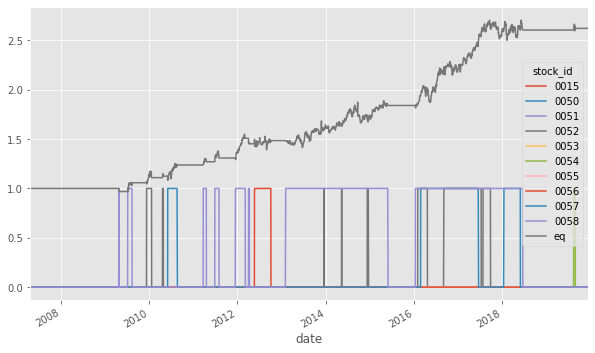

In [27]:
import matplotlib.pyplot as plt

# 報酬率 = 明天的開盤價 / 今天的開盤價
gain = open_.shift(-1).ffill()[sids] / open_.ffill()[sids]
# gain.mean(axis = 1)
# fillna(1)用1填充缺失資料，cumprod累積績效
eq = (gain[hold == 1].mean(axis=1)).fillna(1).cumprod()

draw_df = hold.copy()
draw_df['eq'] = eq
draw_df.plot()

### 不要每天都rebalance
假如今天持有兩檔股票，若股票有增有減，做權益平衡

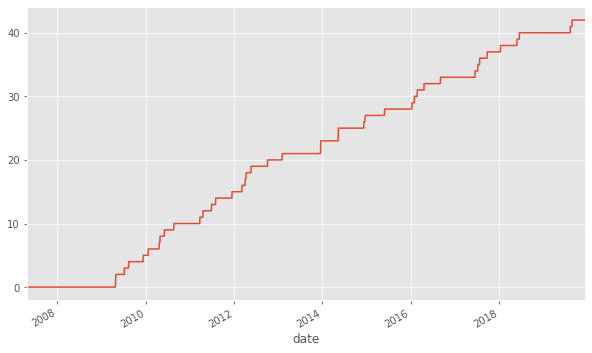

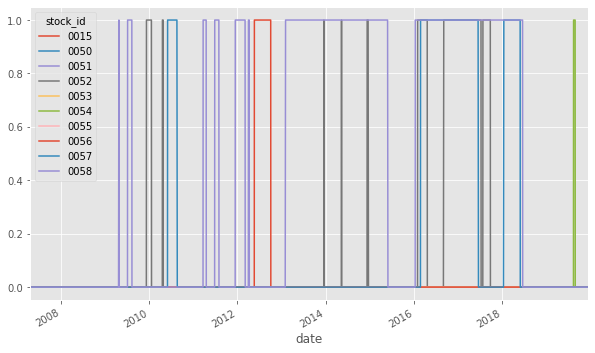

In [33]:
# 當今天股票清單一發生變化時，數值也會增加一單位，可由上圖的數值來區分rebalance(timeperiod)
timeperiod = (hold.diff().abs().sum(axis=1) != 0).cumsum().plot()
hold.plot()

2.3137073044529908

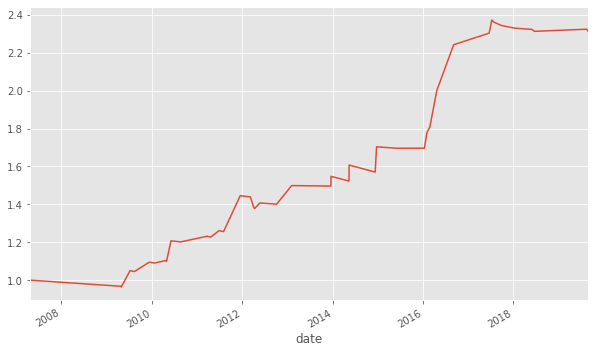

In [42]:
rebalance = (hold.diff().abs().sum(axis=1) != 0).cumsum()
rebalance_hold = hold[rebalance.diff() != 0]
rebalance_gain = gain.groupby(rebalance.values).apply(lambda s:s.cumprod().iloc[-1]) # 整個時間段的績效
rebalance_gain.index = rebalance_hold.index

# 手續費
position_diff = rebalance_hold.div(rebalance_hold.sum(axis=1), axis=0).fillna(0).diff()
tax_ratio = position_diff.copy()
tax_ratio[tax_ratio < 0] *= (1.425/1000 + 3/1000)
tax_ratio[tax_ratio > 0] *= (1.425/1000)
tax_ratio = tax_ratio.abs().sum(axis=1)

# 總績效
eq2 = (rebalance_gain[rebalance_hold == 1].mean(axis=1).fillna(1) * (1 - tax_ratio)).cumprod() 
eq2.plot()
eq2.iloc[-1]

## 考慮手續費

In [59]:
import pickle
pickle.dump(eq, open('return_history.pkl', 'wb'))